# Carla Python API Tutorial
From tutorial found [here](https://arijitray1993.github.io/CARLA_tutorial/).

In [1]:
import carla
import random
import cv2
import skimage.measure as measure

#in synchronous mode, sensor data must be added to a queue
import queue

In [2]:
client = carla.Client('carla_server', 2000)
client.set_timeout(60.0)

client.get_available_maps()

['/Game/Carla/Maps/Town03',
 '/Game/Carla/Maps/Town03_Opt',
 '/Game/Carla/Maps/Town10HD',
 '/Game/Carla/Maps/Town01_Opt',
 '/Game/Carla/Maps/Town05_Opt',
 '/Game/Carla/Maps/Town04',
 '/Game/Carla/Maps/Town10HD_Opt',
 '/Game/Carla/Maps/Town02_Opt',
 '/Game/Carla/Maps/Town02',
 '/Game/Carla/Maps/Town04_Opt',
 '/Game/Carla/Maps/Town05',
 '/Game/Carla/Maps/Town01']

In [3]:
world = client.load_world('Town04')
settings = world.get_settings()
settings.fixed_delta_seconds = 0.05 #must be less than 0.1, or else physics will be noisy
#must use fixed delta seconds and synchronous mode for python api controlled sim, or else 
#camera and sensor data may not match simulation properly and will be noisy 
settings.synchronous_mode = True 
world.apply_settings(settings)

3

In [4]:
weather = carla.WeatherParameters(
    cloudiness=20.0,
    precipitation=20.0,
    sun_altitude_angle=110.0)

#or use precomputed weathers
#weather = carla.WeatherParameters.WetCloudySunset

world.set_weather(weather)

In [5]:
blueprints = world.get_blueprint_library().filter('*')
for blueprint in random.sample(list(blueprints), 5):
    print(blueprint.id)
    for attr in blueprint:
       print('  - {}'.format(attr))

static.prop.creasedbox02
  - ActorAttribute(id=size,type=str,value=small(const))
  - ActorAttribute(id=role_name,type=str,value=prop)
vehicle.bh.crossbike
  - ActorAttribute(id=generation,type=int,value=1(const))
  - ActorAttribute(id=number_of_wheels,type=int,value=2(const))
  - ActorAttribute(id=sticky_control,type=bool,value=True)
  - ActorAttribute(id=driver_id,type=int,value=2)
  - ActorAttribute(id=object_type,type=str,value=(const))
  - ActorAttribute(id=color,type=Color,value=Color(20,78,217,255))
  - ActorAttribute(id=role_name,type=str,value=autopilot)
vehicle.carlamotors.carlacola
  - ActorAttribute(id=generation,type=int,value=1(const))
  - ActorAttribute(id=number_of_wheels,type=int,value=4(const))
  - ActorAttribute(id=sticky_control,type=bool,value=True)
  - ActorAttribute(id=object_type,type=str,value=(const))
  - ActorAttribute(id=color,type=Color,value=Color(255,68,0,255))
  - ActorAttribute(id=role_name,type=str,value=autopilot)
vehicle.bmw.grandtourer
  - ActorAttri

In [6]:
actor_list = []

In [7]:
blueprint_library = world.get_blueprint_library()
bp = random.choice(blueprint_library.filter('vehicle')) # lets choose a vehicle at random

# lets choose a random spawn point
transform = random.choice(world.get_map().get_spawn_points()) 

#spawn a vehicle
vehicle = world.spawn_actor(bp, transform) 
actor_list.append(vehicle)

vehicle.set_autopilot(True)

In [8]:
#lets create waypoints for driving the vehicle around automatically
m = world.get_map()
waypoint = m.get_waypoint(transform.location)

#lets add more vehicles
for _ in range(0, 200):
    transform = random.choice(m.get_spawn_points())

    bp_vehicle = random.choice(blueprint_library.filter('vehicle'))

    # This time we are using try_spawn_actor. If the spot is already
    # occupied by another object, the function will return None.
    other_vehicle = world.try_spawn_actor(bp_vehicle, transform)
    if other_vehicle is not None:
        #print(npc)
        other_vehicle.set_autopilot(True)
        actor_list.append(other_vehicle)

In [9]:
# Adding random objects
blueprint_library = world.get_blueprint_library()
weirdobj_bp = blueprint_library.find('static.prop.fountain')
weirdobj_transform = random.choice(world.get_map().get_spawn_points())
weirdobj_transform = carla.Transform(carla.Location(x=230, y=195, z=40), carla.Rotation(yaw=180))
weird_obj = world.try_spawn_actor(weirdobj_bp, weirdobj_transform)
actor_list.append(weird_obj)

In [10]:
#example for getting camera image
camera_bp = blueprint_library.find('sensor.camera.rgb')
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
camera = world.spawn_actor(camera_bp, camera_transform, attach_to=vehicle)
image_queue = queue.Queue()
camera.listen(image_queue.put)
actor_list.append(camera)

#example for getting depth camera image
camera_depth = blueprint_library.find('sensor.camera.depth')
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
camera_d = world.spawn_actor(camera_depth, camera_transform, attach_to=vehicle)
image_queue_depth = queue.Queue()
camera_d.listen(image_queue_depth.put)
actor_list.append(camera_d)

#example for getting semantic segmentation camera image
camera_semseg = blueprint_library.find('sensor.camera.semantic_segmentation')
camera_transform = carla.Transform(carla.Location(x=1.5, z=2.4))
camera_seg = world.spawn_actor(camera_semseg, camera_transform, attach_to=vehicle)
image_queue_seg = queue.Queue()
camera_seg.listen(image_queue_seg.put)
actor_list.append(camera_seg)

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pycocotools
import math
from scipy.spatial import distance

def get_mask(seg_im, rgb_value):
    # rgb_value should be somethiing like np.uint8([[[70, 70, 70]]])
    # seg_im should be in HSV
    
    hsv_value = cv2.cvtColor(rgb_value, cv2.COLOR_RGB2HSV)
    
    hsv_low = np.array([[[hsv_value[0][0][0]-5, hsv_value[0][0][1], hsv_value[0][0][2]-5]]])
    hsv_high = np.array([[[hsv_value[0][0][0]+5, hsv_value[0][0][1], hsv_value[0][0][2]+5]]])
    
    mask = cv2.inRange(seg_im, hsv_low, hsv_high)
    return mask

def get_bbox_from_mask(mask):
    label_mask = measure.label(mask)
    props = measure.regionprops(label_mask)
    
    return [prop.bbox for prop in props]

In [12]:
## get location of weird obj
world.tick()

6

In [13]:
#rgb camera
image = image_queue.get()

#semantic segmentation camera
image_seg  = image_queue_seg.get()

#depth camera
image_depth = image_queue_depth.get()

In [14]:
image.save_to_disk("test_images/%06d.png" %(image.frame))
image_seg.save_to_disk("test_images/%06d_semseg.png" %(image.frame), carla.ColorConverter.CityScapesPalette)
image_depth.save_to_disk("test_images/%06d_depth.png" %(image.frame), carla.ColorConverter.LogarithmicDepth)

'test_images/000006_depth.png'

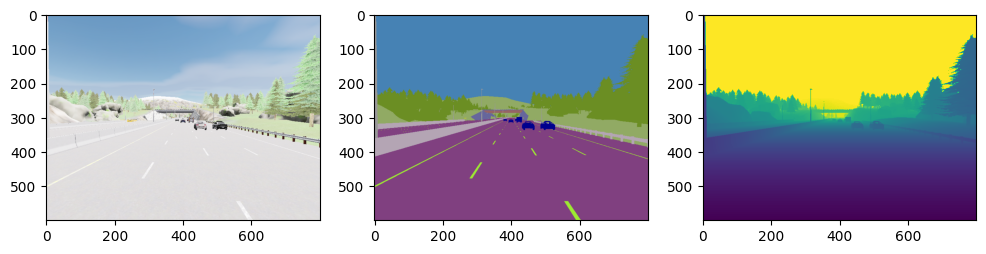

In [15]:
img = mpimg.imread("test_images/%06d.png" % image.frame)
img_semseg = mpimg.imread("test_images/%06d_semseg.png" % image.frame)
img_depth = mpimg.imread("test_images/%06d_depth.png" % image.frame)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,18))
ax1.imshow(img)
ax2.imshow(img_semseg)
ax3.imshow(img_depth) 
plt.show()

In [16]:
img_semseg_bgr = cv2.imread("test_images/%06d_semseg.png" % image.frame)
img_semseg_bgr = cv2.cvtColor(img_semseg_bgr, cv2.COLOR_BGRA2BGR)
img_semseg_hsv = cv2.cvtColor(img_semseg_bgr, cv2.COLOR_BGR2HSV) # color wise segmentation is better in hsv space

In [17]:
#bgr value exmaples of few objects: full list at https://carla.readthedocs.io/en/0.9.9/ref_sensors/ 
object_list = {
    'building': np.uint8([[[70, 70, 70]]]),
    'pedestrian': np.uint8([[[220,  20,  60]]]),
    'vegetation': np.uint8([[[107, 142,  35]]]),
    'car': np.uint8([[[  0,   0, 142]]]),
    'fence': np.uint8([[[190, 153, 153]]]),
    'traffic_sign': np.uint8([[[220, 220,   0]]]),
    'pole': np.uint8([[[153, 153, 153]]]),
    'wall': np.uint8([[[102, 102, 156]]])
}

In [18]:
mask = get_mask(img_semseg_hsv, object_list['car'])
bboxes = get_bbox_from_mask(mask)

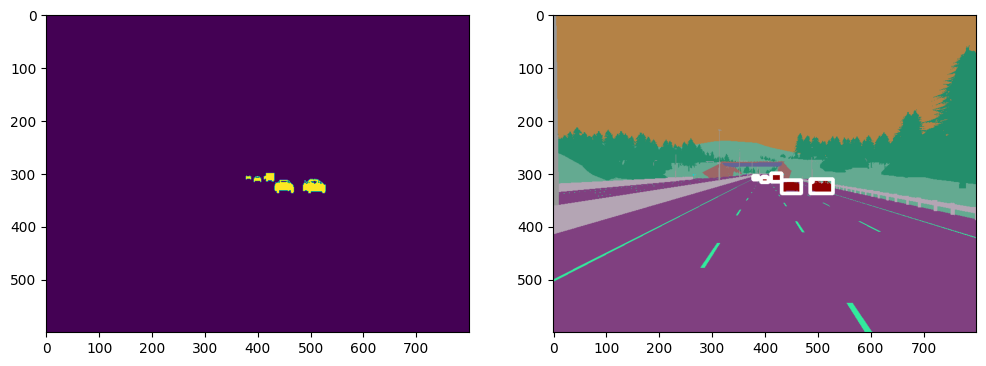

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12,18))
ax1.imshow(mask)
for bbox in bboxes:
    minr, minc, maxr, maxc = bbox
    cv2.rectangle(img_semseg_bgr, (minc,minr), (maxc, maxr), (255,255,255), 6)

ax2.imshow(img_semseg_bgr)
plt.show()

In [20]:
weirdobj_loc = weird_obj.get_location()
# returns x, y, z as weirdobj_loc.x, weirdobj_loc.y, weirdobj_loc.z

weirdobj_transform = weird_obj.get_transform()
# returns x, y, z as weirdobj_transform.location.x, weirdobj_transform.location.y, weirdobj_transform.location.z
# also returns pitch, yaw, roll as weirdobj_transform.rotation.pitch, weirdobj_transform.rotation.yaw, weirdobj_transform.rotation.roll

#similarly we can get the camera transform
camera_transform = camera.get_transform()

In [21]:
waypoint = random.choice(waypoint.next(1.5)) #navigate to next waypoint on map 1.5 meters ahead
vehicle.set_transform(waypoint.transform)

In [ ]:
# from detectron2.structures import BoxMode
# #in sychronous mode, client controls step of simulation and number of steps
# dataset_dicts = []
# global_count=0
# for i in range(100):
#     #step
#     world.tick()

#     #rgb camera
#     image = image_queue.get()

#     #semantic segmentation camera
#     image_seg  = image_queue_seg.get()
#     #image_seg.convert(carla.ColorConverter.CityScapesPalette)

#     #depth camera
#     image_depth = image_queue_depth.get()
#     #image_depth.convert(carla.ColorConverter.LogarithmicDepth)
    
    
#     if i%10==0:
#         image.save_to_disk("test_images/%06d.png" %(image.frame))
#         image_seg.save_to_disk("test_images/%06d_semseg.png" %(image.frame), carla.ColorConverter.CityScapesPalette)
#         image_depth.save_to_disk("test_images/%06d_depth.png" %(image.frame), carla.ColorConverter.LogarithmicDepth)

#         img = mpimg.imread("test_images/%06d.png" % image.frame)
#         img_semseg = mpimg.imread("test_images/%06d_semseg.png" % image.frame)
#         img_depth = mpimg.imread("test_images/%06d_depth.png" % image.frame)
        
#         ## COCO format stuff, each image needs to have these keys
#         height, width = cv2.imread("test_images/%06d.png" %(image.frame)).shape[:2]
#         record = {}
#         record['file_name'] = "test_images/%06d.png" %(image.frame)
#         global_count+=1
#         record['image_id'] = global_count
#         record['height'] = height
#         record['width'] = width
        
        
#         fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize = (12,18))
#         ax1.imshow(img)
#         ax2.imshow(img_semseg)
#         ax3.imshow(img_depth) 
        
        
        
#         ## compute bboxes from semseg
#         img_semseg_bgr = cv2.imread("test_images/%06d_semseg.png" % image.frame)
#         img_semseg_bgr = cv2.cvtColor(img_semseg_bgr, cv2.COLOR_BGRA2BGR)
#         img_semseg_hsv = cv2.cvtColor(img_semseg_bgr, cv2.COLOR_BGR2HSV) # color wise segmentation is better in hsv space

#         #bgr value exmaples of few objects: full list at https://carla.readthedocs.io/en/0.9.9/ref_sensors/ 
#         object_list = dict()
#         object_list['building'] = np.uint8([[[70, 70, 70]]])        
#         object_list['pedestrian'] = np.uint8([[[220, 20, 60]]])
#         object_list['vegetation'] = np.uint8([[[107, 142, 35]]])
#         object_list['car'] = np.uint8([[[ 0, 0, 142]]])
#         object_list['fence'] = np.uint8([[[ 190, 153, 153]]])
#         object_list['traffic_sign'] = np.uint8([[[220, 220, 0]]])
#         object_list['pole'] = np.uint8([[[153, 153, 153]]])
#         object_list['wall'] = np.uint8([[[102, 102, 156]]])
        
#         object_bboxes = dict()
#         objects = []
#         obj_id = 0
#         obj2id = dict()
#         for obj in object_list:
#             mask = get_mask(img_semseg_hsv, object_list[obj])
#             bboxes = get_bbox_from_mask(mask)
#             object_bboxes[obj] = bboxes
            
#             #let's visualize car bboxes
#             if obj=='car':
#                 ax4.imshow(mask)
#                 for bbox in bboxes:
#                     minr, minc, maxr, maxc = bbox
#                     cv2.rectangle(img_semseg_bgr, (minc,minr), (maxc, maxr), (255,255,255), 6)
        
#                 ax5.imshow(img_semseg_bgr)
            
#             #lets put things in coco format for finetuning mask rcnn
#             for bbox in bboxes:
#                 minr, minc, maxr, maxc = bbox
#                 obj_mask = np.copy(mask)
#                 obj_mask[:minr] = 0
#                 obj_mask[:, :minc] = 0
#                 obj_mask[maxr+1:] = 0
#                 obj_mask[:, maxc+1:] = 0

#                 coco_rle_mask = pycocotools.mask.encode(np.array(obj_mask, order="F"))
                
#                 obj_ann = {
#                         'bbox': [minc, minr, maxc, maxr],
#                         'bbox_mode': BoxMode.XYXY_ABS,
#                         'segmentation': coco_rle_mask,
#                         'category_id': obj_id
#                 }
#                 objects.append(obj_ann)
                
#                 obj_id+=1
#                 obj2id[obj] = obj_id
        
        

#         record['annotations'] = objects
        
#         print(record)
        
#         dataset_dicts.append(record)
                
            
#         #plt.show()
    
#     #drive vehicle to next waypoint on map
#     waypoint = random.choice(waypoint.next(1.5))
#     vehicle.set_transform(waypoint.transform)

In [22]:
#make sure to destroy all cameras and actors since they remain in the simulator even if you respawn using python. 
#It gets destroyed only if you restart CARLA simulator
camera.destroy()
camera_d.destroy()
camera_seg.destroy()
client.apply_batch([carla.command.DestroyActor(x) for x in actor_list])